In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

pd.set_option("display.precision", 4)

import sys
sys.path.insert(0, '../cmds')

In [53]:
data_file_path = r'C:/Users/20001009/gmo_analysis_data.xlsx'

rets = pd.read_excel(data_file_path,sheet_name='returns (total)').set_index('Date')
rets = rets[['SPY','GMWAX']]

rf = pd.read_excel(data_file_path,sheet_name='risk-free rate')
rf.set_index('Date',inplace=True)

retsx = rets.subtract(rf['US3M'], axis=0)
retsx.dropna(axis=0,inplace=True)


In [54]:
T1 = '2011'
T2 = '2012'
retsx_pre = retsx.loc[:T1,:]
retsx_post = retsx.loc[T2:,:]

keys_subsamps = [f'{retsx_pre.index[0]:%Y}-{retsx_pre.index[-1]:%Y}',
                              f'{retsx_post.index[0]:%Y}-{retsx_post.index[-1]:%Y}',
                              f'{retsx.index[0]:%Y}-{retsx.index[-1]:%Y}']

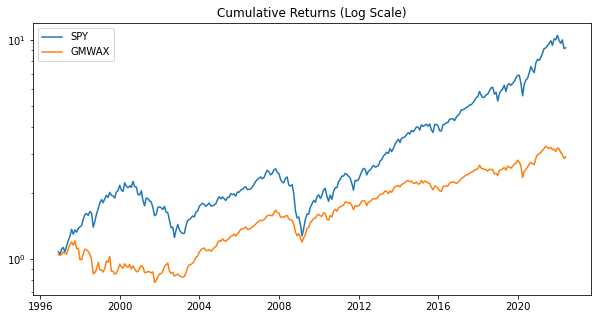

In [55]:
plotdata = (1+rets).cumprod()
fig = plt.figure(figsize=(10,5))
plt.plot(plotdata)
plt.legend(plotdata.columns)
plt.title('Cumulative Returns (Log Scale)')
plt.yscale('log')

In [56]:
def performanceMetrics(retsx):
    metrics = pd.DataFrame(index=retsx.columns)
    metrics['Mean'] = retsx.mean()  * 12
    metrics['Vol'] = retsx.std() * np.sqrt(12)
    metrics['Sharpe'] = (retsx.mean() / retsx.std()) * np.sqrt(12)
    metrics['Var'] = retsx.quantile(.05)

    return metrics



df_all = performanceMetrics(retsx)
df_pre = performanceMetrics(retsx_pre)
df_post = performanceMetrics(retsx_post)

performance = pd.concat([df_pre,df_post,df_all], axis=0, keys=keys_subsamps)
performance.style.format('{:.1%}')


The mean and sharpe changed much since the case, but the volatility changed a little.

In [57]:
def tailRisk(returns):
    metrics = pd.DataFrame(index = returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis() - 3
    metrics['VaR (5th)'] = returns.quantile(.05)
    metrics['CVaR (5th)'] = (returns[returns < returns.quantile(.05)]).mean()
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    metrics['Max Drawdown'] = returns.max()-returns.min()
    
    return metrics

df_pre = tailRisk(retsx_pre)
df_post = tailRisk(retsx_post)
df_all = tailRisk(retsx)

drawdown = pd.concat([df_pre,df_post,df_all], axis=0, keys=keys_subsamps)
drawdown.style.format({
    'Skewness':'{:.2f}',
    'Kurtosis':'{:.2f}',
    'VaR (0.05)':'{:.2f}',
    'CVaR (0.05)':'{:.2f}',
    'Max Drawdown':'{:.2f}',
    'Peak':'{:%Y-%m}',
    'Bottom':'{:%Y-%m}',
    
})

GMWAX has a low tail risk, comparing to SPY across different time period. The tail risk statistics do not vary much between the subsamples.

In [58]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [59]:
df_all = get_ols_metrics(retsx[['SPY']], retsx[['GMWAX']], annualization=12)
df_pre = get_ols_metrics(retsx_pre[['SPY']], retsx_pre[['GMWAX']], annualization=12)
df_post = get_ols_metrics(retsx_post[['SPY']], retsx_post[['GMWAX']], annualization=12)

mktreg = pd.concat([df_pre,df_post,df_all], axis=0, keys=keys_subsamps)
mktreg

mktreg.style.format({
    'alpha': '{:,.2%}'.format,
    'SPY': '{:,.2f}'.format,
    'r-squared': '{:,.2%}'.format,
    'Treynor Ratio': '{:.2f}',
    'Info Ratio': '{:,.2%}'.format,
})

,,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
1996-2011,GMWAX,-0.58%,0.54,50.72%,0.03,-6.56%
2012-2022,GMWAX,-2.84%,0.55,73.50%,0.09,-63.56%
1996-2022,GMWAX,-1.44%,0.54,56.36%,0.05,-19.61%


GMWAX is a low-beta strategy, and it does not vary across time. GMWAX also provides negative alpha, which varies over time.

<font size=5>3. Forecast Regression</font>

In [60]:
sigs = pd.read_excel(r'C:/Users/20001009/gmo_analysis_data.xlsx',sheet_name='signals')
sigs.set_index('Date',inplace=True)
sigs

,DP,EP,US10Y
Date,,,
1996-11-30,2.01,5.14,6.06
1996-12-31,2.00,5.21,6.43
1997-01-31,1.95,5.12,6.53
1997-02-28,1.88,4.98,6.56
1997-03-31,1.90,5.08,6.92
...,...,...,...
2022-01-31,1.33,3.88,1.79
2022-02-28,1.39,4.01,1.83
2022-03-31,1.41,3.87,2.32


In [61]:
# lag the independent variable, so that we can align date stamps and still have lag
sigs_lag = sigs.shift().dropna()

# align the data frames to the same subset of dates
sigs_lag, spy = sigs_lag.align(rets[['SPY']], join='inner',axis=0)

In [62]:
forecasts = rets[['SPY']].expanding().mean().shift(1).dropna()
forecasts.columns = ['Mean']

# Define the models for the other forecasts
model_map = {'DP':['DP'], 'EP':['EP'], 'ALL':sigs.columns}

for model in model_map.keys():
    X = sigs_lag[model_map[model]]
    forecasts[model] = LinearRegression().fit(X,spy).predict(X)
    
forecasts.dropna(inplace=True)
forecasts

,Mean,DP,EP,ALL
Date,,,,
1996-12-31,0.0730,0.0102,0.0099,0.0075
1997-01-31,0.0246,0.0101,0.0101,0.0070
1997-02-28,0.0370,0.0095,0.0098,0.0063
1997-03-31,0.0301,0.0088,0.0095,0.0054
1997-04-30,0.0153,0.0090,0.0097,0.0053
...,...,...,...,...
2022-01-31,0.0088,0.0022,0.0053,0.0045
2022-02-28,0.0086,0.0027,0.0067,0.0055
2022-03-31,0.0085,0.0033,0.0070,0.0062


NameError: name 'plot_data' is not defined

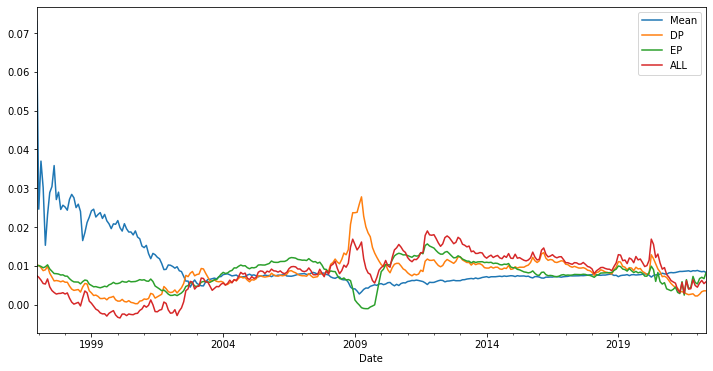

In [74]:
fig, ax = plt.subplots(figsize=(12,6))
forecasts.plot(ax=ax)

plt.legend(plot_data.columns)
plt.title('Forecasted Return')
plt.ylim(-.005,.03)
plt.show()  

In [79]:
target = rets[['SPY']]
resids = forecasts - target.values
sse = (resids ** 2).sum()
rsquared_oos = (1 - sse.divide(sse['Mean'],axis=0)).to_frame()
rsquared_oos.columns = ['R-squared']
rsquared_oos.style.format({' R-squared': '{:,.2%}'.format})

ValueError: Unable to coerce to DataFrame, shape must be (306, 4): given (307, 1)

In [64]:
wts = 100 * forecasts

fund_returns = wts * spy.values
fund_returns.insert(0,'Passive', spy)
fund_returns

,Passive,Mean,DP,EP,ALL
Date,,,,,
1996-12-31,-0.0238,-0.1737,-0.0242,-0.0236,-0.0178
1997-01-31,0.0618,0.1520,0.0623,0.0622,0.0435
1997-02-28,0.0096,0.0354,0.0091,0.0094,0.0060
1997-03-31,-0.0441,-0.1330,-0.0386,-0.0419,-0.0240
1997-04-30,0.0626,0.0957,0.0562,0.0610,0.0332
...,...,...,...,...,...
2022-01-31,-0.0527,-0.0464,-0.0117,-0.0281,-0.0237
2022-02-28,-0.0295,-0.0254,-0.0079,-0.0198,-0.0163
2022-03-31,0.0376,0.0318,0.0125,0.0265,0.0234


In [65]:
print('Correlation of funds performances:')
fund_returns.corr().style.format('{:,.1%}'.format)

Correlation of funds performances:


,Passive,Mean,DP,EP,ALL
Passive,100.0%,81.6%,83.5%,89.3%,79.1%
Mean,81.6%,100.0%,51.0%,71.8%,41.7%
DP,83.5%,51.0%,100.0%,70.0%,91.4%
EP,89.3%,71.8%,70.0%,100.0%,82.1%
ALL,79.1%,41.7%,91.4%,82.1%,100.0%


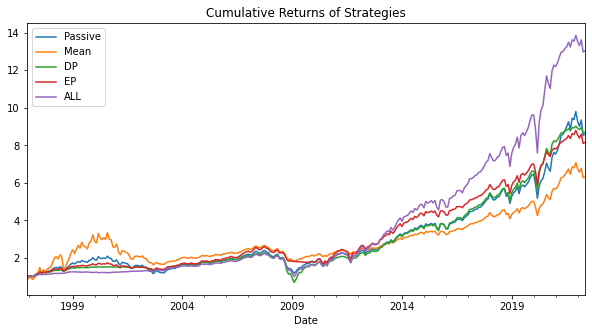

In [66]:
(fund_returns + 1).cumprod().plot(figsize=(10,5), title='Cumulative Returns of Strategies');

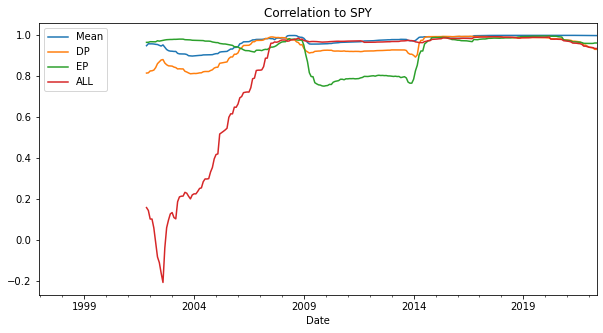

In [67]:
corr_rolling = fund_returns.rolling(60).corr()
dynamic_corrs = (corr_rolling['Passive'].unstack(1))
dynamic_corrs = dynamic_corrs.reindex(columns=fund_returns.columns).drop(columns=['Passive'])
dynamic_corrs.plot(figsize=(10,5),title='Correlation to SPY');

In [70]:
performanceMetrics(fund_returns).style.format('{:,.2%}'.format)

,Mean,Vol,Sharpe,Var
Passive,9.65%,15.31%,63.02%,-7.44%
Mean,9.09%,18.99%,47.89%,-7.19%
DP,9.86%,16.30%,60.48%,-5.58%
EP,8.98%,12.12%,74.13%,-5.58%
ALL,11.25%,15.14%,74.30%,-6.51%


In [71]:
tailRisk(fund_returns).style.format({
    'Skewness':'{:.2f}',
    'Kurtosis':'{:.2f}',
    'VaR (0.05)':'{:.2f}',
    'CVaR (0.05)':'{:.2f}',
    'Max Drawdown':'{:.2f}',
    'Peak':'{:%Y-%m}',
    'Bottom':'{:%Y-%m}',
    'Recover':'{:%Y-%m}'
})

,Skewness,Kurtosis,VaR (5th),CVaR (5th),Min,Max,Max Drawdown
Passive,-0.57,-2.04,-0.0744,-0.0980,-0.1652,0.1270,0.29
Mean,-0.49,4.26,-0.0719,-0.1228,-0.3390,0.2411,0.58
DP,-0.33,7.77,-0.0558,-0.1085,-0.2557,0.2760,0.53
EP,0.04,-0.66,-0.0558,-0.0730,-0.1067,0.1707,0.28
ALL,0.11,2.22,-0.0651,-0.1002,-0.1761,0.2143,0.39


In [72]:
get_ols_metrics(spy, fund_returns, annualization=12).style.format({
    'alpha': '{:,.2%}'.format,
    'SPY': '{:,.2f}'.format,
    'r-squared': '{:,.2%}'.format,
    'Treynor Ratio': '{:.2f}',
    'Info Ratio': '{:,.2%}'.format,
})

,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
Passive,-0.00%,1.00,100.00%,0.10,nan%
Mean,-0.67%,1.01,66.53%,0.09,-6.07%
DP,1.28%,0.89,69.67%,0.11,14.29%
EP,2.17%,0.71,79.68%,0.13,39.66%
ALL,3.70%,0.78,62.56%,0.14,39.96%


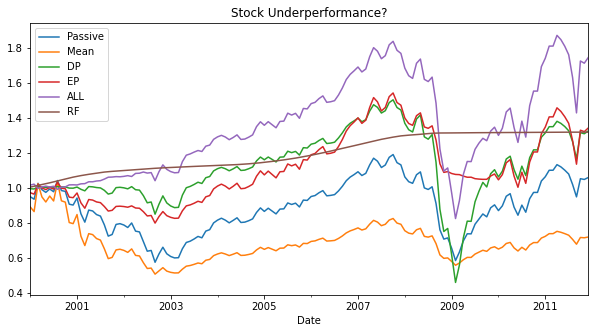

In [73]:
tab2000 = (fund_returns['2000':'2011']+1).cumprod()
tab2000['RF'] = (rf['2000':'2011']+1).cumprod()
tab2000.plot(figsize=(10,5),title='Stock Underperformance?');